# Calculate titers of spike-pseudotyped lentiviruses on different cell lines

In [1]:
import os
import warnings

import math
import numpy as np 

from IPython.display import display, HTML
import matplotlib.pyplot as plt

from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import pandas as pd
from plotnine import *

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config


In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed

In [4]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [5]:
titers = pd.read_csv(config['virus_titers'])

titers = (titers
          .assign(RLUperuL=lambda x: x['RLU_per_well'] / x['uL_virus'],
                  date=lambda x: x['date'].astype(str)
                 )
         )

display(HTML(titers.head().to_html(index=False)))

plasmid,replicate,virus,dilution,uL_virus,RLU_per_well,date,cells,2727_plasmid,amphoB,RLUperuL
2800,rep1,Wu_1,0.50000,50.000,7380696,200122,high,Maxi2020_48hpt,no_amphoB,147613.92
2800,rep1,Wu_1,0.25000,25.000,1875214,200122,high,Maxi2020_48hpt,no_amphoB,75008.56
2800,rep1,Wu_1,0.12500,12.500,385228,200122,high,Maxi2020_48hpt,no_amphoB,30818.24
2800,rep1,Wu_1,0.06250,6.250,91940,200122,high,Maxi2020_48hpt,no_amphoB,14710.40
2800,rep1,Wu_1,0.03125,3.125,27958,200122,high,Maxi2020_48hpt,no_amphoB,8946.56


In [6]:
#pandas make a new df that only has replicate 1

rep1_df = titers.loc[titers['replicate'] == 'rep1']
rep1_df

,plasmid,replicate,virus,dilution,uL_virus,RLU_per_well,date,cells,2727_plasmid,amphoB,RLUperuL
0,2800,rep1,Wu_1,0.500000,50.000000,7380696,200122,high,Maxi2020_48hpt,no_amphoB,147613.92
1,2800,rep1,Wu_1,0.250000,25.000000,1875214,200122,high,Maxi2020_48hpt,no_amphoB,75008.56
2,2800,rep1,Wu_1,0.125000,12.500000,385228,200122,high,Maxi2020_48hpt,no_amphoB,30818.24
3,2800,rep1,Wu_1,0.062500,6.250000,91940,200122,high,Maxi2020_48hpt,no_amphoB,14710.40
4,2800,rep1,Wu_1,0.031250,3.125000,27958,200122,high,Maxi2020_48hpt,no_amphoB,8946.56
...,...,...,...,...,...,...,...,...,...,...,...
281,2800,rep1,Wu_1,0.062500,6.250000,1041614,80422,high,10cm_pooled,amphoB,166658.24
282,2800,rep1,Wu_1,0.031250,3.125000,518519,80422,high,10cm_pooled,amphoB,165926.08
283,2800,rep1,Wu_1,0.015625,1.562500,262969,80422,high,10cm_pooled,amphoB,168300.16
284,2800,rep1,Wu_1,0.007812,0.781250,115732,80422,high,10cm_pooled,amphoB,148136.96


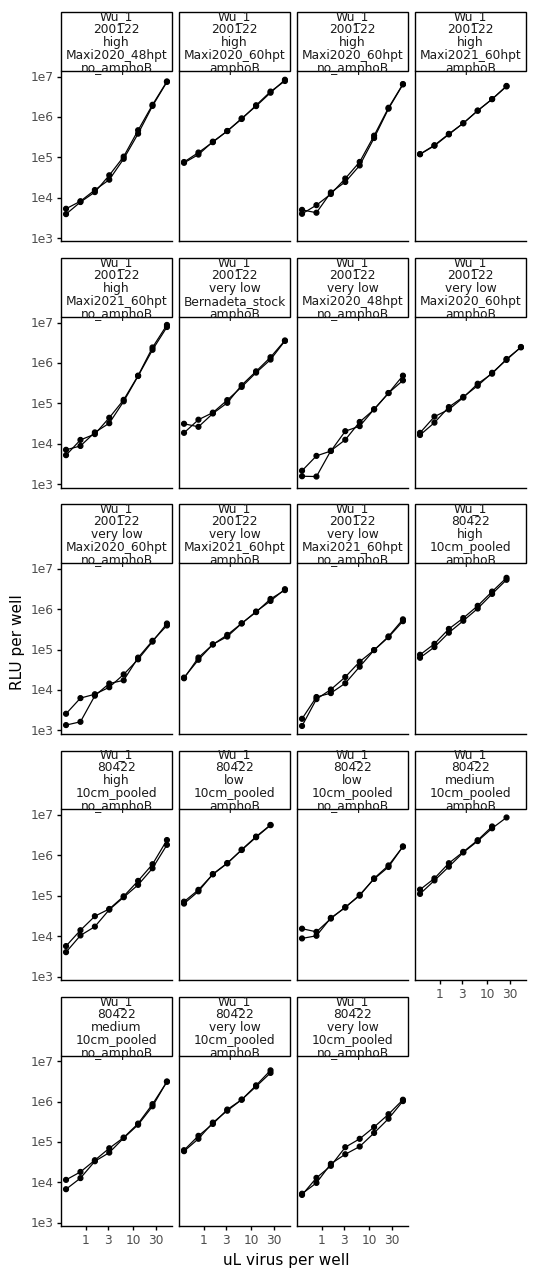

In [22]:
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+cells+2727_plasmid+amphoB', ncol=4) +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(6,15),
           )
     )

_ = p.draw()
plt.savefig('080422titersdilutions.png')

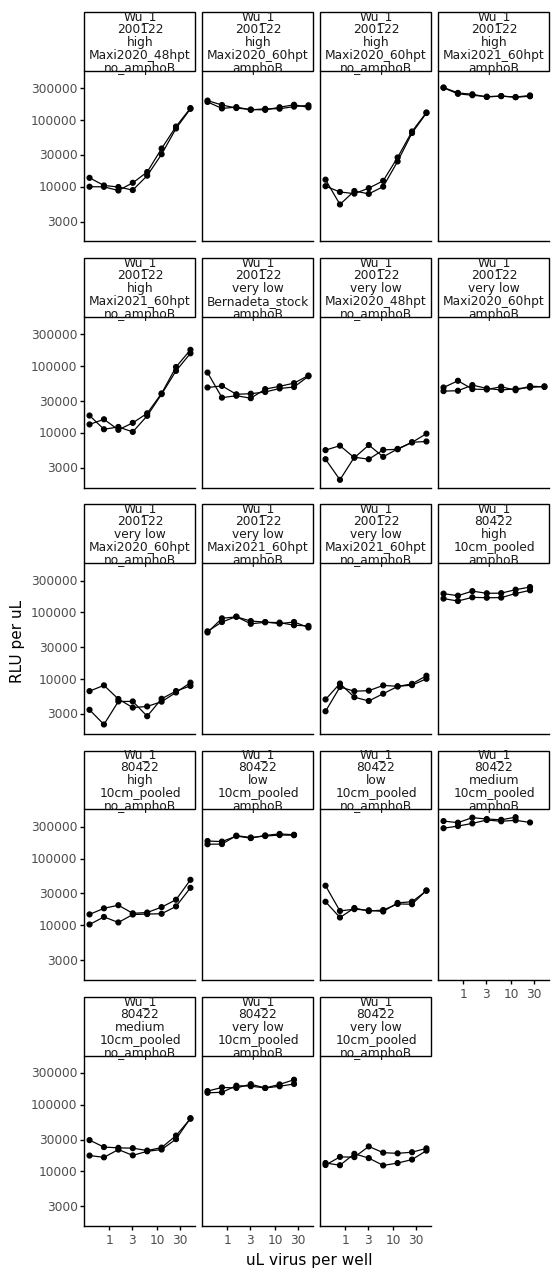

In [23]:
p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLUperuL', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+cells+2727_plasmid+amphoB', ncol=4) +
     scale_y_log10(name='RLU per uL') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(6,15),
           ) 
     )

_ = p.draw()

From visual inspection of the above plots, it appears that only the 5 highest dilutions (i.e., >1uL of virus per well) are reliable enough to calculate titers. 

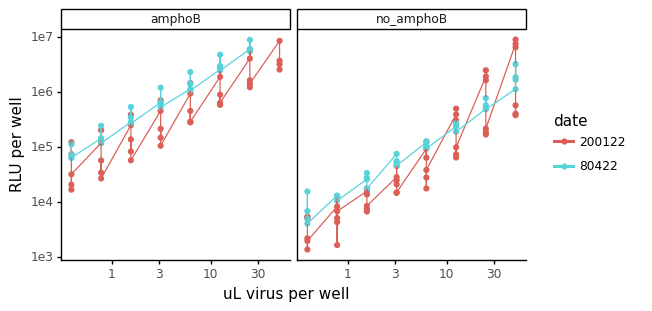

In [9]:
#new
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(rep1_df.dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='date', color= 'date') +
     geom_point(size=1.5) +
     geom_line() +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     facet_wrap('amphoB', ncol=2) +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(6,3),
           )
     )

_ = p.draw()
plt.savefig('080422titersdilutions.png')

In [10]:
#new
average_titers1 = (titers
                  .dropna() # missing values for some replicates
                  .query('uL_virus > 1') # drop lowest concentration of virus
                  .groupby(['virus', 'replicate', 'date', 'cells', '2727_plasmid', 'amphoB','dilution'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers1.head().to_html(index=False)))

virus,replicate,date,cells,2727_plasmid,amphoB,dilution,mean_RLUperuL
Wu_1,rep1,200122,high,Maxi2020_48hpt,no_amphoB,0.015625,9940.48
Wu_1,rep1,200122,high,Maxi2020_48hpt,no_amphoB,0.031250,8946.56
Wu_1,rep1,200122,high,Maxi2020_48hpt,no_amphoB,0.062500,14710.40
Wu_1,rep1,200122,high,Maxi2020_48hpt,no_amphoB,0.125000,30818.24
Wu_1,rep1,200122,high,Maxi2020_48hpt,no_amphoB,0.250000,75008.56


In [11]:
average_titers = (titers
                  .dropna() # missing values for some replicates
                  .query('uL_virus > 1') # drop lowest concentration of virus
                  .groupby(['virus', 'replicate', 'date', 'cells', '2727_plasmid', 'amphoB'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers.head().to_html(index=False)))

virus,replicate,date,cells,2727_plasmid,amphoB,mean_RLUperuL
Wu_1,rep1,200122,high,Maxi2020_48hpt,no_amphoB,47839.693333
Wu_1,rep1,200122,high,Maxi2020_60hpt,amphoB,153512.693333
Wu_1,rep1,200122,high,Maxi2020_60hpt,no_amphoB,40372.710000
Wu_1,rep1,200122,high,Maxi2021_60hpt,amphoB,230195.432000
Wu_1,rep1,200122,high,Maxi2021_60hpt,no_amphoB,59686.550000


In [12]:
cat_order = ['very low', 'low', 'medium', 'high']
average_titers['cells'] = pd.Categorical(average_titers['cells'], categories=cat_order, ordered=True)

average_titers

,virus,replicate,date,cells,2727_plasmid,amphoB,mean_RLUperuL
0,Wu_1,rep1,200122,high,Maxi2020_48hpt,no_amphoB,47839.693333
1,Wu_1,rep1,200122,high,Maxi2020_60hpt,amphoB,153512.693333
2,Wu_1,rep1,200122,high,Maxi2020_60hpt,no_amphoB,40372.710000
3,Wu_1,rep1,200122,high,Maxi2021_60hpt,amphoB,230195.432000
4,Wu_1,rep1,200122,high,Maxi2021_60hpt,no_amphoB,59686.550000
5,Wu_1,rep1,200122,very low,Bernadeta_stock,amphoB,48910.933333
6,Wu_1,rep1,200122,very low,Maxi2020_48hpt,no_amphoB,5959.903333
7,Wu_1,rep1,200122,very low,Maxi2020_60hpt,amphoB,47823.730000
8,Wu_1,rep1,200122,very low,Maxi2020_60hpt,no_amphoB,5281.416667
9,Wu_1,rep1,200122,very low,Maxi2021_60hpt,amphoB,70423.453333


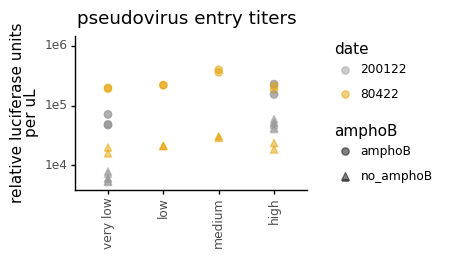

In [13]:
p = (ggplot(average_titers, 
            aes(x='cells', y='mean_RLUperuL', color='date', shape = 'amphoB')
           ) +
     geom_point(size=2.5, alpha=0.5)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(average_titers['virus'].nunique()*3,2),
           axis_title_x=element_blank(),
          ) +
     scale_y_log10(limits=[5e3,1.1e6]) +
     ylab('relative luciferase units\nper uL')+
     labs(title='pseudovirus entry titers') +
     scale_color_manual(values=CBPALETTE)
    )

_ = p.draw()

Calculate how much virus to use in neut assays:

In [14]:
target_RLU = 2e5
uL_virus_per_well = 50

dilute_virus = (average_titers
                .groupby(['virus', 'date', 'cells', '2727_plasmid','amphoB'])
                .agg(RLUperuL=pd.NamedAgg(column='mean_RLUperuL', aggfunc=np.mean))
                .reset_index()
                .assign(target_RLU = target_RLU,
                        uL_virus_per_well = uL_virus_per_well,
                        dilution_factor = lambda x: x['RLUperuL']/target_RLU*uL_virus_per_well,
                        uL_per_8mL = lambda x: 8000/x['dilution_factor'],
                        media_for_8ml = lambda x: 8000 - 8000/x['dilution_factor']
                       )
               )


titerfile = os.path.join(resultsdir, 'virus_titers.csv')
print(f"Saving to {titerfile}")

dilute_virus.to_csv(titerfile, index=False)

display(HTML(dilute_virus.to_html(index=False)))

Saving to results/virus_titers.csv


virus,date,cells,2727_plasmid,amphoB,RLUperuL,target_RLU,uL_virus_per_well,dilution_factor,uL_per_8mL,media_for_8ml
Wu_1,200122,very low,10cm_pooled,amphoB,NaN,200000.0,50,NaN,NaN,NaN
Wu_1,200122,very low,10cm_pooled,no_amphoB,NaN,200000.0,50,NaN,NaN,NaN
Wu_1,200122,very low,Bernadeta_stock,amphoB,48134.986667,200000.0,50,12.033747,664.797109,7335.202891
Wu_1,200122,very low,Bernadeta_stock,no_amphoB,NaN,200000.0,50,NaN,NaN,NaN
Wu_1,200122,very low,Maxi2020_48hpt,amphoB,NaN,200000.0,50,NaN,NaN,NaN
Wu_1,200122,very low,Maxi2020_48hpt,no_amphoB,6035.725000,200000.0,50,1.508931,5301.765737,2698.234263
Wu_1,200122,very low,Maxi2020_60hpt,amphoB,47475.220000,200000.0,50,11.868805,674.035844,7325.964156
Wu_1,200122,very low,Maxi2020_60hpt,no_amphoB,5345.510000,200000.0,50,1.336378,5986.332455,2013.667545
Wu_1,200122,very low,Maxi2021_60hpt,amphoB,71130.041667,200000.0,50,17.782510,449.880237,7550.119763
Wu_1,200122,very low,Maxi2021_60hpt,no_amphoB,7591.453333,200000.0,50,1.897863,4215.266642,3784.733358


In [15]:
# !jupyter nbconvert calculate_titer.ipynb --to HTML